## 1. A preliminary look at the Bustabit data
<p>The similarities and differences in the behaviors of different people have long been of interest, particularly in psychology and other social science fields. Understanding human behavior in particular contexts can help us to make informed decisions. Consider a game of poker - understanding why players raise, call, and fold in various situations can provide a distinct advantage competitively.</p>
<p>Along these lines, we are going to focus on the behavior on <strong>online gamblers</strong> from a platform called <a href="https://www.bustabit.com" target="_blank">Bustabit</a>. There are a few basic rules for playing a game of Bustabit:</p>
<ol>
<li>You bet a certain amount of money (in Bits, which is 1 / 1,000,000th of a Bitcoin) and you win if you cash out before the game <strong>busts</strong>.</li>
<li>Your win is calculated by the multiplier value at the moment you cashed out. For example, if you bet 100 and the value was 2.50x at the time you cashed out, you win 250. In addition, a percentage <code>Bonus</code> per game is multiplied with your bet and summed to give your final <code>Profit</code> in a winning game. Assuming a <code>Bonus</code> of 1%, your <code>Profit</code> for this round would be <code>(100 x 2.5) + (100 x .01) - 100 = 151</code></li>
<li>The multiplier increases as time goes on, but if you wait too long to cash out, you may bust and lose your money.</li>
<li>Lastly, the house maintains slight advantages because in 1 out of every 100 games, everyone playing busts.</li>
</ol>
<p>Below we see an example of a winning game:</p>
<p><img src="https://assets.datacamp.com/production/project_643/img/bustabit_win.gif" alt></p>
<p>And a losing game, for comparison:</p>
<p><img src="https://assets.datacamp.com/production/project_643/img/bustabit_loss.gif" alt></p>
<p>Our goal will be to define relevant <strong>groups</strong> or <strong>clusters</strong> of Bustabit users to identify what patterns and behaviors of gambling persist. Can we describe a particular group as risk-averse? Is there a set of gamblers that have a strategy that seems to be more successful in the long term?</p>
<p>The data you will be working with includes over 40000 games of Bustabit by a bit over 4000 different players, for a total of 50000 rows (one game played by one player). The data includes the following variables:</p>
<ol>
<li><strong>Id</strong> - Unique identifier for a particular row (game result for one player)</li>
<li><strong>GameID</strong> - Unique identifier for a particular game</li>
<li><strong>Username</strong> - Unique identifier for a particular player</li>
<li><strong>Bet</strong> - The number of Bits (1 / 1,000,000th of a Bitcoin) bet by the player in this game</li>
<li><strong>CashedOut</strong> - The multiplier at which this particular player cashed out</li>
<li><strong>Bonus</strong> - The bonus award (in percent) awarded to this player for the game</li>
<li><strong>Profit</strong> - The amount this player won in the game, calculated as (Bet * CashedOut) + (Bet * Bonus) - Bet</li>
<li><strong>BustedAt</strong> - The multiplier value at which this game busted</li>
<li><strong>PlayDate</strong> - The date and time at which this game took place</li>
</ol>
<p>Let's begin by doing an exploratory dive into the Bustabit data!</p>

In [35]:
# Load the tidyverse
library(tidyverse)

# Read in the bustabit gambling data 
bustabit <- read_csv("datasets/bustabit.csv")

# Look at the first five rows of the data
head(bustabit, 5)

# Find the highest multiplier (BustedAt value) achieved in a game
bustabit %>%
    arrange(desc(BustedAt)) %>%
    slice(1)

Parsed with column specification:
cols(
  Id = col_double(),
  GameID = col_double(),
  Username = col_character(),
  Bet = col_double(),
  CashedOut = col_double(),
  Bonus = col_double(),
  Profit = col_double(),
  BustedAt = col_double(),
  PlayDate = col_datetime(format = "")
)


Id,GameID,Username,Bet,CashedOut,Bonus,Profit,BustedAt,PlayDate
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>
14196549,3366002,papai,5,1.20,0.0,1.00,8.24,2016-11-20 19:44:19
10676217,3343882,znay22,3,NA,NA,NA,1.40,2016-11-14 14:21:50
15577107,3374646,rrrrrrrr,4,1.33,3.0,1.44,3.15,2016-11-23 06:39:15
25732127,3429241,sanya1206,10,NA,NA,NA,1.63,2016-12-08 18:13:55
17995432,3389174,ADM,50,1.50,1.4,25.70,2.29,2016-11-27 08:14:48


Id,GameID,Username,Bet,CashedOut,Bonus,Profit,BustedAt,PlayDate
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>
19029273,3395044,Shadowshot,130,2,2.77,133.6,251025.1,2016-11-29 00:03:05


## 2. Deriving relevant features for clustering
<p>The Bustabit data provides us with many features to work with, but to better quantify player behavior, we need to derive some more variables. Currently, we have a <code>Profit</code> column which tells us the amount won in that game, but no indication of how much was lost if the player busted, and no indicator variable quantifying whether the game itself was a win or loss overall. Hence, we will derive or modify the following variables:</p>
<ol>
<li><strong>CashedOut</strong> - If the value for <code>CashedOut</code> is <code>NA</code>, we will set it to be 0.01 greater than the <code>BustedAt</code> value to signify that the user failed to cash out before busting</li>
<li><strong>Profit</strong> - If the value for <code>Profit</code> is <code>NA</code>, we will set it to be zero to indicate no profit for the player in that game</li>
<li><strong>Losses</strong> - If the new value for <code>Profit</code> is zero, we will set this to be the amount the player lost in that game, otherwise we will set it to zero. This value should always be <em>zero or negative</em></li>
<li><strong>GameWon</strong> - If the user made a profit in this game, the value should be 1, and 0 otherwise</li>
<li><strong>GameLost</strong> If the user had a loss in this game, the value should be 1, and 0 otherwise</li>
</ol>

In [37]:
# Create the new feature variables 
bustabit_features <- bustabit %>% 
  mutate(CashedOut = ifelse(is.na(CashedOut), BustedAt + .01, CashedOut),
         Profit = ifelse(is.na(Profit), 0, Profit),
         Losses = ifelse(Profit == 0, -1*Bet, 0),
         GameWon = ifelse(Profit == 0, 0, 1),
         GameLost = ifelse(Profit == 0, 1, 0))

# Look at the first five rows of the features data
head(bustabit_features, 5)


Id,GameID,Username,Bet,CashedOut,Bonus,Profit,BustedAt,PlayDate,Losses,GameWon,GameLost
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>
14196549,3366002,papai,5,1.20,0.0,1.00,8.24,2016-11-20 19:44:19,0,1,0
10676217,3343882,znay22,3,1.41,NA,0.00,1.40,2016-11-14 14:21:50,-3,0,1
15577107,3374646,rrrrrrrr,4,1.33,3.0,1.44,3.15,2016-11-23 06:39:15,0,1,0
25732127,3429241,sanya1206,10,1.64,NA,0.00,1.63,2016-12-08 18:13:55,-10,0,1
17995432,3389174,ADM,50,1.50,1.4,25.70,2.29,2016-11-27 08:14:48,0,1,0


## 3. Creating per-player statistics
<p>The primary task at hand is to cluster Bustabit <strong>players</strong> by their respective gambling habits. Right now, however, we have features at the per-game level. The features we've derived would be great if we were interested in clustering properties of the games themselves - we know things about the BustedAt multiplier, the time the game took place, and lots more. But to better quantify player behavior, we must group the data by player (<code>Username</code>) to begin thinking about the relationship and similarity between groups of players. Some per-player features we will create are:</p>
<ol>
<li><strong>AverageCashedOut</strong> - The average multiplier at which the player cashes out</li>
<li><strong>AverageBet</strong> - The average bet made by the player</li>
<li><strong>TotalProfit</strong> - The total profits over time for the player</li>
<li><strong>TotalLosses</strong> - The total losses over time for the player</li>
<li><strong>GamesWon</strong> - The total number of individual games the player won</li>
<li><strong>GamesLost</strong> - The total number of individual games the player lost</li>
</ol>
<p>With these variables, we will be able to potentially group similar users based on their typical Bustabit gambling behavior.</p>

In [39]:
# Group by players to create per-player summary statistics
bustabit_clus <- bustabit_features %>%
  group_by(Username) %>%
  summarize(AverageCashedOut = mean(CashedOut), 
            AverageBet = mean(Bet),
            TotalProfit = sum(Profit),
            TotalLosses = sum(Losses), 
            GamesWon = sum(GameWon),
            GamesLost = sum(GameLost))

# View the first five rows of the data
head(bustabit_clus, n = 5)

`summarise()` ungrouping output (override with `.groups` argument)


Username,AverageCashedOut,AverageBet,TotalProfit,TotalLosses,GamesWon,GamesLost
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
----------------,1.040000,10.33333,0.70,-8,2,1
--dilib--,1.505000,210.75000,371.37,-1239,2,6
-31337-,1.220000,32.50000,21.50,-55,3,1
-Nothing-,1.417077,322.87692,3794.31,-6915,42,23
-Tachyon,1.246000,1024.80000,629.68,-2124,4,1


## 4. Scaling and normalization of the derived features
<p>The variables are on very different <strong>scales</strong> right now. For example, <code>AverageBet</code> is in bits (1/1000000 of a Bitcoin), <code>AverageCashedOut</code> is a multiplier, and <code>GamesLost</code> and <code>GamesWon</code> are counts. As a result, we would like to <strong>normalize</strong> the variables such that across clustering algorithms, they will have approximately equal weighting.</p>
<p>One thing to think about is that in many cases, we may actually want a particular numeric variable to maintain a higher weight. This could occur if there is some prior knowledge regarding, for example, which variable might be most important in terms of defining similar Bustabit behavior. In this case, without that prior knowledge, we will forego the weighting of variables and scale everything. We are going to use <strong>mean-sd</strong> standardization to scale the data. Note that this is also known as a <strong>Z-score</strong>.</p>
<p>Note that we could compute the Z-scores by using the base R function <code>scale()</code>, but we're going to write our own function in order to get the practice.</p>

In [41]:
# Create the mean-sd standardization function
mean_sd_standard <- function(x) {
    (x-mean(x))/sd(x)
}

# Apply the function to each numeric variable in the clustering set
bustabit_standardized <- bustabit_clus %>%
    mutate_if(is.numeric, mean_sd_standard)
              
# Summarize our standardized data
summary(bustabit_standardized)

   Username         AverageCashedOut     AverageBet       TotalProfit      
 Length:4149        Min.   :-0.76289   Min.   :-0.1773   Min.   :-0.09052  
 Class :character   1st Qu.:-0.28157   1st Qu.:-0.1765   1st Qu.:-0.09050  
 Mode  :character   Median :-0.18056   Median :-0.1711   Median :-0.08974  
                    Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.00000  
                    3rd Qu.: 0.02752   3rd Qu.:-0.1384   3rd Qu.:-0.08183  
                    Max.   :41.72651   Max.   :24.9971   Max.   :40.73652  
  TotalLosses           GamesWon         GamesLost       
 Min.   :-41.84541   Min.   :-0.4320   Min.   :-0.41356  
 1st Qu.:  0.09837   1st Qu.:-0.3696   1st Qu.:-0.41356  
 Median :  0.10847   Median :-0.3071   Median :-0.33306  
 Mean   :  0.00000   Mean   : 0.0000   Mean   : 0.00000  
 3rd Qu.:  0.10916   3rd Qu.:-0.1196   3rd Qu.:-0.09156  
 Max.   :  0.10916   Max.   :13.2534   Max.   :19.30911  

## 5. Cluster the player data using K means
<p>With standardized data of per-player features, we are now ready to use K means clustering in order to cluster the players based on their online gambling behavior. K means is implemented in R in the <code>kmeans()</code> function from the stats package. This function requires the <code>centers</code> parameter, which represents the number of clusters to use. </p>
<p>Without prior knowledge, it is often difficult to know what an appropriate choice for the number of clusters is. We will begin by choosing <strong>five</strong>. This choice is rather arbitrary, but represents a good initial compromise between choosing too many clusters (which reduces the interpretability of the final results), and choosing too few clusters (which may not capture the distinctive behaviors effectively). Feel free to play around with other choices for the number of clusters and see what you get instead!</p>
<p>One subtlety to note - because the K means algorithm uses a random start, we are going to set a random seed first in order to ensure the results are reproducible.</p>

In [43]:
# Choose 20190101 as our random seed
set.seed(20190101)

# Cluster the players using kmeans with five clusters
cluster_solution <- bustabit_standardized %>%
                    select(-Username) %>%
                    kmeans(centers = 5)

# Store the cluster assignments back into the clustering data frame object
bustabit_clus$cluster <- factor(cluster_solution$cluster)

# Look at the distribution of cluster assignments
table(bustabit_clus$cluster)


   1    2    3    4    5 
 412   16   17 3626   78 

## 6. Compute averages for each cluster
<p>We have a clustering assignment which maps every Bustabit gambler to one of five different groups. To begin to assess the quality and distinctiveness of these groups, we are going to look at <strong>group averages</strong> for each cluster across the original variables in our clustering dataset. This will, for example, allow us to see which cluster tends to make the largest bets, which cluster tends to win the most games, and which cluster tends to lose the most money. This will provide us with our first clear indication as to whether the behaviors of the groups appear distinctive!</p>

In [45]:
#Group by the cluster assignment and calculate averages
bustabit_clus_avg <- bustabit_clus %>%
    group_by(cluster) %>%
    summarize_if(is.numeric, mean)

# View the resulting table
bustabit_clus_avg

cluster,AverageCashedOut,AverageBet,TotalProfit,TotalLosses,GamesWon,GamesLost
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.915776,1633.2292,19362.9909,-19205.1165,27.0606796,21.036408
2,2.470024,298945.6618,1198191.1631,-1056062.1875,10.5625000,8.062500
3,27.448235,1278.2574,619.4041,-581.2941,0.7058824,1.529412
4,1.699993,4024.1102,4272.6656,-4365.7788,2.9109211,2.128792
5,1.758407,432.1163,18568.1141,-16724.0641,87.1794872,61.205128


## 7. Visualize the clusters with a Parallel Coordinate Plot
<p>We can already learn a bit about our cluster groupings by looking at the previous table. We can clearly see that there is a group that makes very large bets, a group that tends to cash out at very high multiplier values, and a group that has played many games of Bustabit. We can visualize these group differences graphically using a Parallel Coordinate Plot or PCP. To do so, we will introduce one more kind of scaling: min-max scaling, which forces each variable to fall between 0 and 1.</p>
<p>Other choices of scaling, such as the Z-score method from before, can work effectively as well. However, min-max scaling has the advantage of <strong>interpretability</strong> - a value of 1 for a particular variable indicates that cluster has the highest value compared to all other clusters, and a value of 0 indicates that it has the lowest. This can help make relative comparisons between the clusters more clear.</p>
<p>The <code>ggparcoord()</code> function from <code>GGally</code> will be used to produce a Parallel Coordinate Plot. Note that this has a built-in argument <code>scale</code> to perform different scaling options, including min-max scaling. We will set this option to <code>"globalminmax"</code> to perform no scaling, and write our own scaling routine for practice. If you are interested, you can look at the function definition for <code>ggparcoord()</code> to help you write our scaling function!</p>

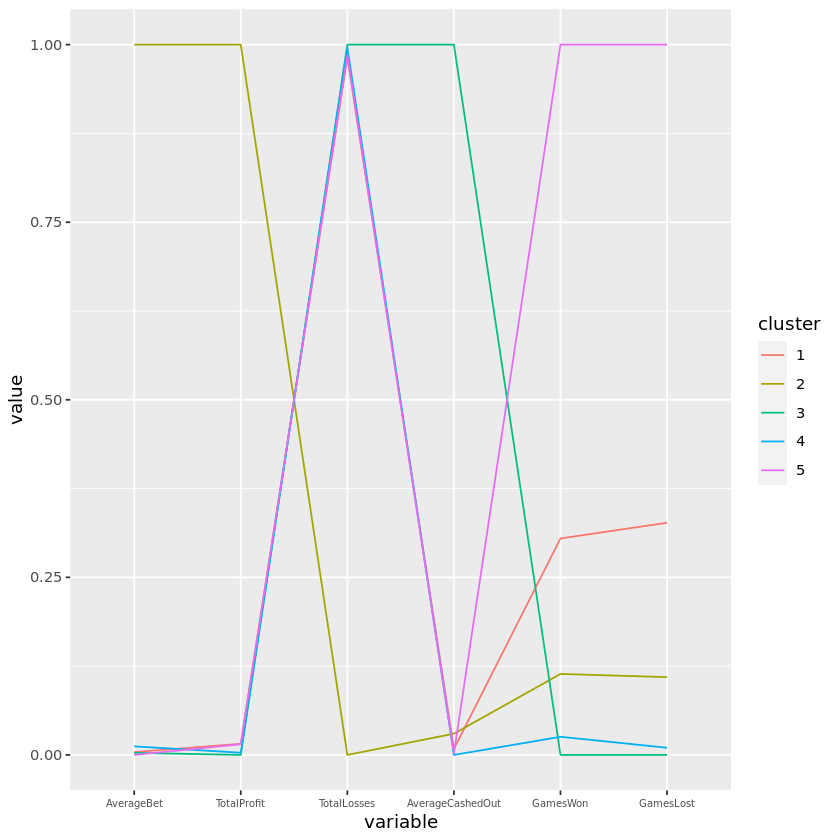

In [47]:
# Create the min-max scaling function
min_max_standard <- function(x) {
    (x -  min(x)) / (max(x) - min(x))
}

# Apply this function to each numeric variable in the bustabit_clus_avg object
bustabit_avg_minmax <- bustabit_clus_avg %>%
    mutate_if(is.numeric, min_max_standard)

# Load the GGally package
library(GGally)
              
# Create a parallel coordinate plot of the values
ggparcoord(bustabit_avg_minmax, columns = 2:ncol(bustabit_avg_minmax), 
          groupColumn = "cluster", scale = "globalminmax", order = "skewness")+
            theme(axis.text.x = element_text(size=6))

## 8. Visualize the clusters with Principal Components
<p>One issue with plots like the previous is that they get more unwieldy as we continue to add variables. One way to solve this is to use the Principal Components of a dataset in order to reduce the dimensionality to aid in visualization. Essentially, this is a two-stage process:</p>
<ol>
<li>We extract the principal components in order to reduce the dimensionality of the dataset so that we can produce a scatterplot in two dimensions that captures the underlying structure of the higher-dimensional data.</li>
<li>We then produce a scatterplot of each observation (in this case, each player) across the two Principal Components and color according to their cluster assignment in order to visualize the separation of the clusters.</li>
</ol>
<p>This plot provides interesting information in terms of the similarity of any two players. In fact, you will see that players who fall close to the boundaries of clusters might be the ones that exhibit the gambling behavior of a couple of different clusters. After you produce your plot, try to determine which clusters seem to be the most "different." Also, try playing around with different projections of the data, such as PC3 vs. PC2, or PC3 vs. PC1, to see if you can find one that better differentiates the groups.</p>

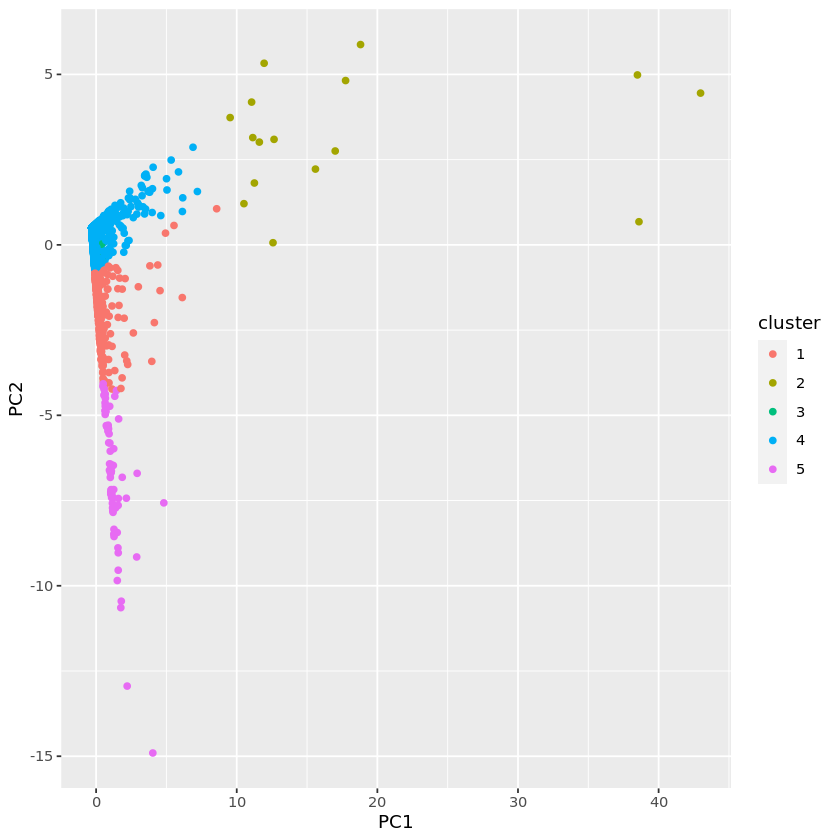

In [49]:
# Calculate the principal components of the standardized data
my_pc <- as.data.frame(prcomp(bustabit_standardized[,-1])$x)

# Store the cluster assignments in the new data frame
my_pc$cluster <- bustabit_clus$cluster

# Use ggplot() to plot PC2 vs PC1, and color by the cluster assignment
p1 <- ggplot(my_pc, aes(x = PC1, y= PC2, color = cluster)) + geom_point()

# View the resulting plot
p1

## 9. Analyzing the groups of gamblers our solution uncovered
<p>Though most of the statistical and programmatical work has been completed, possibly the most important part of a cluster analysis is to interpret the resulting clusters. This often is the most desired aspect of the analysis by clients, who are hoping to use the results of your analysis to inform better business decision making and actionable items. As a final step, we'll use the parallel coordinate plot and cluster means table to interpret the Bustabit gambling user groups! Roughly speaking, we can breakdown the groups as follows:</p>
<p><strong><p style="color:#d95f02">Cautious Commoners:</p></strong> This is the largest of the five clusters, and might be described as the more casual Bustabit players. They've played the fewest number of games overall, and tend to make more conservative bets in general. </p>
<p><strong><p style="color:#66a61e">Strategic Addicts:</p></strong> These users play a lot of games on Bustabit, but tend to keep their bets under control. As a result, they've made on average a net positive earnings from the site, in spite of having the most games played. They seem to maintain a strategy (or an automated script/bot) that works to earn them money.</p>
<p><strong><p style="color:#7570b3">Risky Commoners:</p></strong> These users seem to be a step above the Cautious Commoners in their Bustabit gambling habits, making larger average bets, and playing a larger number of games on the site. As a result, though they have about the same number of average games won as the Risk Takers, they have a significantly higher number of games lost.</p>
<p><strong><p style="color:#1b9e77">Risk Takers: </p></strong> These users have played only a couple games on average, but their average cashed out value is significantly higher than the other clusters, indicating that they tend to wait for the multiplier to increase to large values before cashing out.</p>
<p><strong><p style="color:#e7298a">High Rollers:</p></strong> High bets are the name of the game for this group. They bet large sums of money in each game, although they tend to cash out at lower multipliers and thus play the game more conservatively, particularly compared to the Risk Takers. Interestingly, these users have also on average earned a net positive earnings from their games played.</p>

In [51]:
# Assign cluster names to clusters 1 through 5 in order
cluster_names <- c(
    "Risky Commoners",
    "High Rollers",
    "Risk Takers",
    "Cautious Commoners",
    "Strategic Addicts"
)

# Append the cluster names to the cluster means table
bustabit_clus_avg_named <- bustabit_clus_avg %>%
    cbind(Name = cluster_names)

# View the cluster means table with your appended cluster names
bustabit_clus_avg_named

cluster,AverageCashedOut,AverageBet,TotalProfit,TotalLosses,GamesWon,GamesLost,Name
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1.915776,1633.2292,19362.9909,-19205.1165,27.0606796,21.036408,Risky Commoners
2,2.470024,298945.6618,1198191.1631,-1056062.1875,10.5625000,8.062500,High Rollers
3,27.448235,1278.2574,619.4041,-581.2941,0.7058824,1.529412,Risk Takers
4,1.699993,4024.1102,4272.6656,-4365.7788,2.9109211,2.128792,Cautious Commoners
5,1.758407,432.1163,18568.1141,-16724.0641,87.1794872,61.205128,Strategic Addicts
